# Scraping and Analyzing the SF Chronicle

In Python, scrape sfchronicle.com for article information, like title, author, and date using html requests. Analyze website sections for most-used words using nltk for natural-language processing and matplotlib for visualizations. Important for linguists to understand language in journalism.

## The San Francisco Chronicle

In this assignment, you'll scrape text from [The San Francisco Chronicle](https://www.sfchronicle.com/) newspaper and then analyze the text.

The Chronicle is organized by category into article lists. For example, there's a [Local](https://www.sfchronicle.com/local/) list, [Sports](https://www.sfchronicle.com/sports/) list, and [Food](https://www.sfchronicle.com/food/) list.

The goal of exercises 1.1 - 1.3 is to scrape articles from the Chronicle for analysis in exercise 1.4.

__Exercise 1.1.__ Write a function that extracts all of the links to articles in a Chronicle article list. The function should:

* Have a parameter `url` for the URL of the article list.

* Return a list of article URLs (each URL should be a string).

Test your function on 2-3 different categories to make sure it works.

Hints:

* Be polite and save time by setting up [requests_cache](https://pypi.python.org/pypi/requests-cache) before you write your function.

* You can use any of the XML/HTML parsing packages mentioned in class. Choose one and use it throughout the entire assignment.

In [1]:
import numpy as np
import pandas as pd
import requests
import requests_cache
import lxml.html as lx
import matplotlib.pyplot as plt
import nltk
import nltk.corpus
# import time

requests_cache.install_cache("mycache")

In [2]:
def read_html(url):
    response = requests.get(url)
    response.raise_for_status()
    return lx.fromstring(response.text)

In [3]:
def get_article_list(url):
    """takes in url of an SF Chronicle article list
    returns list of links to the articles as strings"""
    if url[-1] == "/":
        url = url.strip("/")
    html = read_html(url)
    link_list = html.xpath("//h3[@class = 'headline display-above']/a | //h2[contains(@class, 'headline')]/a | //div[contains(@class, 'item rel-links')]/h4/a")
    new_list = []
    for link in link_list:
        l = link.attrib["href"]
        if l[0] == "/":
            new_list.append(url + l)
        else:
            new_list.append(l)
    return new_list

In [9]:
# test function with local articles
get_article_list("https://www.sfchronicle.com/local/")

['https://www.sfchronicle.com/local/bayarea/article/Neighbors-furious-over-noxious-odor-from-13635071.php',
 'https://www.sfchronicle.com/local/politics/article/California-Republicans-hope-their-next-leader-can-13634407.php',
 'https://www.sfchronicle.com/local/politics/article/SF-supervisors-ask-city-s-General-Hospital-why-13634951.php',
 'https://www.sfchronicle.com/local/crime/article/ICE-says-Napa-deputy-shooting-could-have-been-13635545.php',
 'https://www.sfchronicle.com/local/crime/article/50-people-arrested-in-Tenderloin-dragnet-focused-13634837.php',
 'https://www.sfchronicle.com/local/crime/article/Vallejo-couple-indicted-for-allegedly-making-13634690.php',
 'https://www.sfchronicle.com/local/bayarea/article/She-had-vision-and-drive-but-job-loss-could-have-13500895.php',
 'https://www.sfchronicle.com/local/bayarea/article/Season-of-Sharing-South-Bay-family-received-help-13496742.php',
 'https://www.sfchronicle.com/local/bayarea/article/Multiple-sclerosis-changed-their-lives-B

In [5]:
# test function with politics articles
get_article_list("https://www.sfchronicle.com/elections/")

['https://www.sfchronicle.com/elections/politics/article/Bay-Area-political-events-Legislators-town-13637118.php',
 'https://www.sfchronicle.com/elections/politics/article/Train-to-nowhere-Here-s-how-high-speed-project-13621347.php',
 'https://www.sfchronicle.com/elections/politics/article/2020-campaign-starts-now-GOP-targets-13617068.php',
 'https://www.sfchronicle.com/elections/politics/article/Gavin-Newsom-endorses-Kamala-Harris-for-president-13621397.php',
 'https://www.sfchronicle.com/elections/politics/article/Kamala-Harris-anti-lynching-bill-gets-second-13617352.php',
 'https://www.sfchronicle.com/elections/politics/article/Poll-Kamala-Harris-Joe-Biden-generate-most-13592830.php',
 'https://www.sfchronicle.com/elections/politics/article/SF-Supervisor-Ronen-wants-Harvey-Milk-s-name-13592436.php',
 'https://www.sfchronicle.com/elections/politics/article/How-did-California-Dems-win-close-House-races-13591298.php',
 'https://www.sfchronicle.com/elections/news/article/Kamala-Harris-s

__Exercise 1.2.__ Write a function that extracts data from a Chronicle article. The function should:

* Have a parameter `url` for the URL of the article.

* Return a dictionary with keys for:
    + `url`: The URL of the article.
    + `title`: The title of the article.
    + `text`: The complete text of the article.
    + `author`: The author's name (if available) or a suitable missing value.
    + `date`: The date and time the article was published.
    + `date_updated`: The date and time the article was last updated (if available) or a suitable missing value.

For example, for [this article](https://www.sfchronicle.com/homeandgarden/article/Gardenlust-looks-at-best-21st-century-13580871.php) your function should return a dictionary with the form:
```js
{'url': 'https://www.sfchronicle.com/homeandgarden/article/Gardenlust-looks-at-best-21st-century-13580871.php',
 'title': '‘Gardenlust’ looks at best 21st century gardens in the world',
 'text': 'The book...',
 'author': 'Pam Peirce',
 'date': '2019-02-01T18:02:33+00:00',
 'date_updated': '2019-02-01T18:12:53+00:00'}
```
The value of the `text` field is omitted here to save space. Your function should return the full text in the `text` field.

Hints:

* Many parsing packages allow you to delete elements from an HTML document. Deleting elements is one way to avoid extracting unwanted tags.
* You can union multiple XPath paths with `|`.

In [6]:
def extract_article_info(url):
    """takes in a url of an article
    and returns article info in a dictionary"""
    info = {}
    html = read_html(url)
    info["url"] = html.xpath("//meta[@property = 'og:url']/@content")[0]
    info["title"] = html.xpath("//meta[@property = 'og:title']/@content")[0]
    text = html.xpath("//section[contains(@class, 'body')]//p | //div[@class = 'text-block']//p")
    text_list = []
    for p in text:
        text_list.append(p.text_content().strip(" \r\n"))
    info["text"] = " ".join(text_list)
    
    # unique list separated with " & " in case there are multiple authors:
    author = list(set(html.xpath("//meta[@name = 'author.name']/@content | //meta[@name = 'sailthru.author']/@content")))
    if author == [] or author[0] == "":
        author = html.xpath("//div[@class = 'author']//a | //div[contains(@class, 'author')]//span")
        author_list = []
        for a in author:
            author_list.append(a.text_content().replace("By ", "").strip(" \n"))
        info["author"] = " & ".join(author_list)
    else:
        info["author"] = " & ".join(author)
        
    try:
        info["date"] = html.xpath("//meta[@name = 'og:datePublished']/@content | //meta[@name = 'sailthru.date']/@content | //time[@itemprop = 'datePublished']/@datetime")[0]
    except:
        try:
            info["date"] = html.xpath("//div[@class = 'date']")[0].text_content()
        except:
            info["date"] = ""
        
    try:
        info["date_updated"] = html.xpath("//time[@itemprop = 'dateModified']/@datetime")[0]
    except:
        try:
            info["date_updated"] = html.xpath("//div[contains(@class, 'byline')]/span[@class = 'dateline']")[1].text_content().replace("Updated: ", "")
        except:
            info["date_updated"] = ""
    return info

In [7]:
# test with article
extract_article_info("https://datebook.sfchronicle.com/movies-tv/the-hidden-world-a-touching-finish-to-the-how-to-train-your-dragon-series")

{'url': 'https://datebook.sfchronicle.com/movies-tv/the-hidden-world-a-touching-finish-to-the-how-to-train-your-dragon-series',
 'title': '‘The Hidden World’ brings a touching finish to the ‘How to Train Your Dragon’ series',
 'text': 'The third installment in the animated “How to Train Your Dragon” series is a lovely movie that takes real chances. It moves the story forward considerably, so that it would be hard for the filmmakers to go back on the idea of this being the last of a trilogy. And it contains two sequences that are practically avant-garde in their freedom and audacity. The title is “How to Train Your Dragon: The Hidden World,” and the hidden world, in this case, is a utopia for dragons that exists at the end of the Earth. It’s a place of legend and is believed to be myth, but if it exists, it would solve the big problem troubling every nice person in the movie: In a hostile world, it’s very hard to keep dragons safe. The setting is a fantasy Viking land that never existed

In [8]:
# test with another article
extract_article_info("https://www.sfchronicle.com/politics/article/Feinstein-goes-toe-to-toe-with-Green-New-Deal-13638416.php")

{'url': 'https://www.sfchronicle.com/politics/article/Feinstein-goes-toe-to-toe-with-Green-New-Deal-13638416.php',
 'title': "Feinstein's tense exchange with Green New Deal kids: 'I know what I'm doing'",
 'text': "Typically when young people visit their senator’s office, they go home with a bunch of grip-and-grin photos showing them shaking hands with the lawmaker. But when an environmental activist group brought several children to Sen. Dianne Feinstein’s San Francisco office Friday to lobby her to back the Green New Deal, what they got was more of a finger-wagging than a handshake. The group, the Sunrise Movement, posted a video that promptly went viral of Bay Area kids ages 7 to 16 quarreling with the 85-year-old Democrat, who was just elected to her fifth full term. The Sunrise Movement wants lawmakers to pass the Green New Deal, a nonbinding proposal backed by first-term Democratic Rep. Alexandria Ocasio-Cortez of New York and Sen. Ed Markey, D-Mass., that calls for the U.S. to r

In [9]:
# another article
extract_article_info("https://www.sfchronicle.com/bayarea/article/Public-Defender-Jeff-Adachi-dies-13638785.php")

{'url': 'https://www.sfchronicle.com/bayarea/article/Public-Defender-Jeff-Adachi-dies-13638785.php',
 'title': 'SF Public Defender Jeff Adachi dies',
 'text': 'San Francisco Public Defender Jeff Adachi, a renowned advocate for the accused and an outspoken watchdog on police misconduct, has died. He was 59. Mayor London Breed confirmed Friday night that Adachi had died, saying that San Francisco had “lost a dedicated public servant.” He was the only elected public defender in California. The exact circumstances and cause of Adachi’s death were not immediately known, but sources said he died of a heart attack. “As one of the few elected public defenders in our country, Jeff always stood up for those who didn’t have a voice, have been ignored and overlooked, and who needed a real champion,” Breed said in a statement. “He was committed not only to the fight for justice in the courtroom, but he was also a relentless advocate for criminal justice reform. “Jeff led the way on progressive poli

In [10]:
# one more article
extract_article_info("https://projects.sfchronicle.com/2018/stem-cells/politics/")

{'url': 'https://projects.sfchronicle.com/2018/stem-cells/politics/',
 'title': "California's stem cell bet: Lofty promises, limited results",
 'text': 'It was an extraordinary political proposal: Approve a $3 billion bond measure to fund the cutting-edge science of stem cell therapy, and soon some of the world’s cruelest diseases and most disabling injuries could be eradicated. The 2004 measure was Proposition 71, the California Stem Cell Research and Cures Initiative. The campaign to pass it was led by a Palo Alto real estate developer whose son suffered from an incurable illness that he believed stem cells, the keystones of human biology, could heal. Other supporters\xa0included preeminent scientists, Hollywood celebrities, business leaders and elite investors. The need was urgent, they said. Federal restrictions had recently been imposed on funding research involving human embryonic stem cells, then the most auspicious\xa0field of study. Among the campaign’s promises: Nearly half o

__Exercise 1.3.__ Use your functions from exercises 1.1 and 1.2 to get data frames of articles for the "Biz+Tech" category as well as two other categories of your choosing (except for "Vault: Archive", "Podcasts", and "In Depth").

Add a column to each that indicates the category, then combine them into one big data frame. Clean up the data, stripping excess whitespace and converting columns to appropriate dtypes.

The `text` column of this data frame will be your corpus for natural language processing in exercise 1.4.

In [11]:
def create_dataframe(url):
    """given a url to a list of articles
    returns a dataframe with information about all those articles"""
    links = get_article_list(url)
    dicts = [extract_article_info(link) for link in links]
    # https://stackoverflow.com/questions/20638006/convert-list-of-dictionaries-to-a-pandas-dataframe
    return pd.DataFrame(dicts)

In [12]:
biz_tech = create_dataframe("https://www.sfchronicle.com/business/")
biz_tech

,author,date,date_updated,text,title,url
0,Shwanika Narayan,2019-02-22T12:00:00+00:00,2019-02-22T12:00:34+00:00,One of San Francisco’s last traditional men’s ...,The Hound Gentlemen's Clothiers finds buyer on...,https://www.sfchronicle.com/business/article/T...
1,Tal Kopan,2019-02-22T02:04:26+00:00,2019-02-22T02:05:15+00:00,"WASHINGTON — After nearly two years of delays,...",Trump administration begins effort to strip wo...,https://www.sfchronicle.com/business/article/T...
2,Cecilia Kang,2019-02-22T01:08:05+00:00,2019-02-22T01:40:22+00:00,WASHINGTON — More than a dozen children’s advo...,Consumer groups accuse Facebook of duping chil...,https://www.sfchronicle.com/business/article/C...
3,Daisuke Wakabayashi and Sapna Maheshwari,2019-02-21T21:51:39+00:00,,"Nestlé, Epic Games and other major brands said...",Advertisers boycott YouTube after pedophiles s...,https://www.sfchronicle.com/business/article/A...
4,Cnet,2019-02-24T01:08:47+00:00,2019-02-24T01:10:18+00:00,Cree BR30 Cnet rating: 4.5 stars out of 5 The ...,Four great LED floodlight options,https://www.sfchronicle.com/technology/cnet/ar...
5,"YURI KAGEYAMA, AP Business Writer",2019-02-22T02:11:41+00:00,2019-02-22T02:22:04+00:00,TOKYO (AP) — Asian shares were mostly lower Fr...,Asian shares mostly lower as investors watch t...,https://www.sfchronicle.com/news/world/article...
6,"YURI KAGEYAMA and MATT OTT, AP Business Writer",2019-02-22T12:31:39+00:00,2019-02-22T12:35:07+00:00,TOKYO (AP) — Global shares were mixed Friday a...,Global shares mixed as investors watch trade t...,https://www.sfchronicle.com/news/world/article...
7,"ALEX VEIGA, AP Business Writer",2019-02-22T22:05:21+00:00,2019-02-22T22:24:56+00:00,Technology and health care companies led U.S. ...,"Stocks climb, giving S&P 500 its 4th straight ...",https://www.sfchronicle.com/news/article/US-st...
8,"JOE McDONALD, AP Business Writer",2019-02-21T04:22:10+00:00,2019-02-21T04:24:15+00:00,BEIJING (AP) — Asian stock markets were little...,Asian stocks change little ahead of more US-Ch...,https://www.sfchronicle.com/news/us/article/US...
9,Neal E. Boudette,2019-02-23T01:40:46+00:00,2019-02-23T01:41:38+00:00,After lurching from crisis to crisis last year...,"Tesla's top lawyer departs, other problems lin...",https://www.sfchronicle.com/business/article/T...


In [13]:
local = create_dataframe("https://www.sfchronicle.com/local/")
local

,author,date,date_updated,text,title,url
0,Sarah Ravani,2019-02-22T00:34:04+00:00,2019-02-22T00:35:30+00:00,"For months, Sandra Montgomery has watched from...",Oakland school rebuild means construction disr...,https://www.sfchronicle.com/bayarea/article/Ne...
1,Joe Garofoli,2019-02-22T00:15:31+00:00,2019-02-22T00:17:10+00:00,The California Republican Party has never been...,California Republicans hope their next leader ...,https://www.sfchronicle.com/politics/article/C...
2,Trisha Thadani,2019-02-22T00:42:55+00:00,2019-02-22T00:43:45+00:00,Flabbergasted by recent reports of San Francis...,SF supervisors ask city's General Hospital why...,https://www.sfchronicle.com/politics/article/S...
3,Lauren Hernández,2019-02-22T04:35:13+00:00,2019-02-22T04:35:54+00:00,Federal immigration officials said Thursday th...,Immigration officials say Napa deputy shooting...,https://www.sfchronicle.com/crime/article/ICE-...
4,Evan Sernoffsky,2019-02-22T02:19:58+00:00,2019-02-22T02:21:19+00:00,A dragnet focused on capturing wanted fugitive...,50 people arrested in Tenderloin dragnet focus...,https://www.sfchronicle.com/crime/article/50-p...
5,Sarah Ravani,2019-02-22T00:59:54+00:00,2019-02-22T01:01:21+00:00,A wife and husband who owned and operated an e...,Vallejo couple indicted for allegedly making T...,https://www.sfchronicle.com/crime/article/Vall...
6,Kimberly Veklerov,2018-12-31T23:42:17+00:00,,Tyler Roberson had it all planned — at least t...,"She had vision and drive, but job loss could h...",https://www.sfchronicle.com/bayarea/article/Sh...
7,J.D. Morris,2018-12-30T05:53:03+00:00,2018-12-30T05:54:07+00:00,Citlali Gonzalez-Watson and Justin Watson were...,Season of Sharing: South Bay family received h...,https://www.sfchronicle.com/bayarea/article/Se...
8,Kevin Fagan,2018-12-25T02:09:19+00:00,2018-12-25T02:10:14+00:00,"Many years ago, when his body was strong and t...",Multiple sclerosis changed their lives. But th...,https://www.sfchronicle.com/bayarea/article/Mu...
9,Sophia Kunthara,2018-12-22T05:42:36+00:00,2018-12-22T16:26:59+00:00,The one-story house that sits on Mandarin Aven...,Lisa Johnson had lived in her beloved house he...,https://www.sfchronicle.com/bayarea/article/Li...


In [14]:
politics = create_dataframe("https://www.sfchronicle.com/elections/")
politics

,author,date,date_updated,text,title,url
0,Chronicle staff report,2019-02-22T18:03:55+00:00,,Upcoming political events in the Bay Area. SAT...,Bay Area political events: Legislators' town h...,https://www.sfchronicle.com/politics/article/B...
1,Kurtis Alexander & Rachel Swan,2019-02-17T12:00:00+00:00,2019-02-17T18:02:25+00:00,It’s the railway dream that bedazzled Californ...,Train to nowhere? Here's how high-speed projec...,https://www.sfchronicle.com/politics/article/T...
2,John Wildermuth,2019-02-17T22:08:48+00:00,2019-02-17T22:09:44+00:00,In an all-out effort to show that their disast...,2020 campaign starts now: GOP targets Californ...,https://www.sfchronicle.com/politics/article/2...
3,Joe Garofoli,2019-02-16T02:58:44+00:00,2019-02-16T02:59:55+00:00,Gov. Gavin Newsom endorsed Sen. Kamala Harris ...,Gavin Newsom endorses Kamala Harris for president,https://www.sfchronicle.com/politics/article/G...
4,Tal Kopan,2019-02-14T22:03:53+00:00,2019-02-14T22:05:26+00:00,WASHINGTON — Sen. Kamala Harris’ effort to mak...,Kamala Harris' anti-lynching bill gets second ...,https://www.sfchronicle.com/politics/article/K...
5,Joe Garofoli,2019-02-06T13:00:00+00:00,,Sen. Kamala Harris and former Vice President J...,"Poll: Kamala Harris, Joe Biden generate most e...",https://www.sfchronicle.com/politics/article/P...
6,Trisha Thadani,2019-02-06T02:45:02+00:00,2019-02-06T02:46:22+00:00,A proposed sign for San Francisco Internationa...,SF Supervisor Ronen wants Harvey Milk's name b...,https://www.sfchronicle.com/politics/article/S...
7,John Wildermuth,2019-02-06T18:03:06+00:00,2019-02-06T18:03:54+00:00,The blue wave that drowned California Republic...,How did California Dems win close House races?...,https://www.sfchronicle.com/politics/article/H...
8,Bob Egelko,2019-02-05T04:48:31+00:00,2019-02-05T04:50:02+00:00,Sen. Kamala Harris is accusing President Trump...,Kamala Harris says she'll vote against all of ...,https://www.sfchronicle.com/news/article/Kamal...
9,Alexei Koseff,2019-02-05T17:41:13+00:00,2019-02-05T17:42:08+00:00,SACRAMENTO — He has sued the Trump administrat...,"California attorney general to take on Trump, ...",https://www.sfchronicle.com/politics/article/C...


In [15]:
# combine three dataframes into one big dataframe
# http://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
frames = [biz_tech, local, politics]
df = pd.concat(frames)

__Exercise 1.4.__  What topics has the Chronicle covered recently? How does the category affect the topics? Support your analysis with visualizations.

Hints:

*   The [nltk book](http://www.nltk.org/book/) may be helpful here.

*   This question will be easier to do after we've finished NLP in class.

In [41]:
# nltk.download("stopwords")
# nltk.download('punkt')

def process_corpus(list_of_texts):
    """given a list of texts,
    get a list of stemmed words"""
    corpus = " ".join(list_of_texts)
    corpus = corpus.lower()
    corpus = corpus.replace("san francisco", "sanfrancisco")
    corpus = corpus.replace("said", "")
    words = nltk.word_tokenize(corpus)
    stopwords = nltk.corpus.stopwords.words("english")
    corpus = corpus.replace("would", "")
    words2 = [w for w in words if w not in stopwords]
    stemmer = nltk.PorterStemmer()
    words3 = [stemmer.stem(w) for w in words2]
    return words3

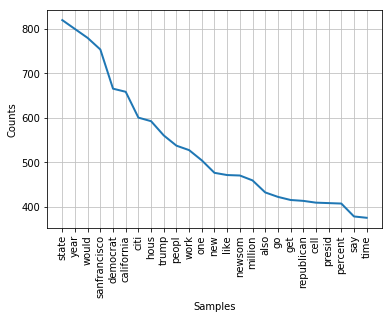

In [44]:
corpus_all = process_corpus(df["text"])

def plot_fq(processed):
    """given a processed corpus
    plot a frequency distribution of the top 25 words"""
    fq = nltk.FreqDist(w for w in processed if w.isalnum())
    %matplotlib inline
    fq.plot(25)
    return
    
plot_fq(corpus_all)

I removed the words "said" and "would" because they are very common but don't add much to the trying to understand the content of the articles. What we can infer from "said" and "would" is that many articles are reporting on what people said, which we can totally expect from a news organization, and that many articles are making promises, or are reporting on people making promises. "Would" means that some action will happen in the future, so these articles must talk a lot of the future.

Out of the three categories (business/tech, local, and politics), the top topics in the news recently are San Francisco, California, Trump, and Democrats. These topics are entirely predictable, since the company is located in San Francisco, California. Trump is always in the news, and local politicians will always talk about Trump. The politics section will undoubtedly mention him very often, as well as Democrats. Interestingly, the articles mention Democrats much more often than Republicans, but that is somewhat expected since California is mostly Democrats. But this also might hint at the political leaning of the news site. There doesn't seem to be any differentiating words for the business and tech section.

Some other interesting and frequent words are "newsom" and "cell." The first is in reference to Gavin Newsom, who is the new governor of California. It is no surprise that the articles mention him frequently. The articles talk about "cell" often, because there are a bunch of very long articles in the local section that talk about stem cells. However, let's go into how the sections differ.

In [45]:
# create a corpus for the different sections
corpus_biz_tech = process_corpus(biz_tech["text"])
corpus_local = process_corpus(local["text"])
corpus_politics = process_corpus(politics["text"])

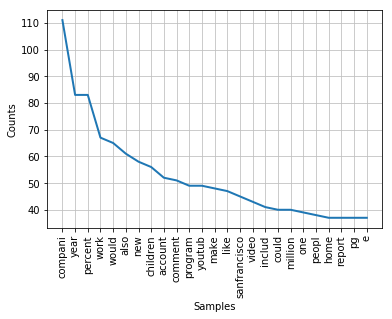

In [46]:
plot_fq(corpus_biz_tech)

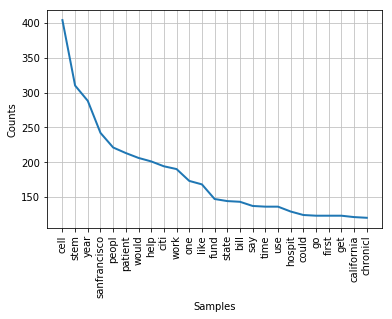

In [47]:
plot_fq(corpus_local)

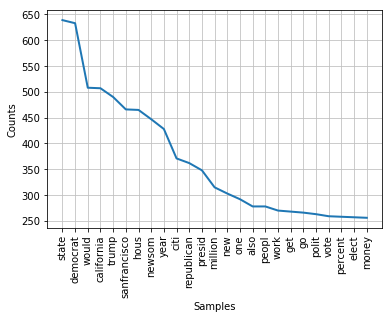

In [48]:
plot_fq(corpus_politics)

The three sections will have different topics. The business and tech section predictably talks a lot about companies, work, accounts, and programs. What is interesting is the focus on YouTube, children, and video. This is likely because of a recent YouTube scandal where advertisers stopped advertising on YouTube because pedophiles were using YouTube to contact children.

The local section focuses on other things: stem cells. On SF Chronicle recently, there are many long articles documenting stem cell research in California. There are other articles talking about patients and hospitals, a topic apparently big in the news recently.

Finally, in the politics section, we find the usual political terms: Democrats, Trump, Newsom, and Republicans. There are no surprises here. We also have words like people, work, president, elect, and money.

It looks like the majority of the articles came from the politics section, which is why political terms dominated the word counts when looking at the articles altogether. It's clear that the certain sections has an affect on the types of articles. Each section focuses on different topics and there doesn't seem to be much overlap, which is good for news readers who only want to read what they want to read.